# Test Complement

The following is a self-contained piece of code testing our application for the auto-correlation computation.


## Initialization


In [2]:
from aspire.volume import Volume
import aspire.volume.volume_synthesis as vsynth
from aspire.source.simulation import Simulation
from aspire.basis import FFBBasis2D
from new_ffb_3d import NewFFBBasis3D as FFBBasis3D

from aspire.covariance import RotCov2D
from aspire.utils.matlab_compat import m_reshape

import numpy as np
import scipy.linalg as sl
import matplotlib.pyplot as plt

from symmetry_detection import calculateAutocorreltation, covariance_coefficients
from symmetry_detection import RANK_TABLE as rank_table

2024-08-06 23:33:56,024 INFO [new_ffb_3d] Expanding 3D map in a frequency-domain Fourier–Bessel basis using the fast method.
2024-08-06 23:34:30,338 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.


## Load volume, calculate basis, Fourier-Bessel coefficients and auto-correlation:


In [3]:
def loadVolume(volume_path: str = None,
            symmetry_str = None,
            V: Volume = None, basis = None, 
            max_eig: int = 20, 
            normalize_volume = False):
    """
    Parameters: 
    Returns: `aspire.Volume`, FFBBasis, coeffs.
    """
    # Default input handling
    if V is None:
        if volume_path is None:
            raise "No volume path or volume were given."
        V = Volume.load(volume_path,dtype=np.float64)
        if V.resolution>300:
            V = V.downsample(300)
        print("Volume shape: \t", V.shape)
        if normalize_volume: # Ensures every pixel in the volume falls within [-1, 1] by dividing each pixel by max(abs(min(V)), abs(max(V)))
            factor = np.max([np.abs(np.min(V)), np.abs(np.max(V))])
            V /= factor
    img_size = V.resolution     
    if basis is None:
        basis = FFBBasis3D( img_size , ell_max=img_size//2 , dtype=np.float64)
    elif img_size<300:
        basis = FFBBasis3D( img_size , ell_max=img_size//2 , dtype=np.float64)
        
    # Estimate the Fourier-Bessel coefficients of the volume
    coeff = basis.evaluate_t(V)
    coeff = basis.to_complex(coeff.asnumpy())


    return V, basis, coeff

## Genarate a simulation, calculate basis,  Fourier-Bessel coefficients of the images and auto-correlation:

In [4]:
def loadSimulation(V: Volume = None,
                    basis = None,
                    n_imgs = None):
    """
    Returns: `aspire.Volume`, FFBBasis, coeffs, acs.
    """        
    if V is None:
        raise "No volume was given."
        
    img_size = V.resolution
    K = int(np.floor(np.pi*img_size//2))
    
    # Genarate the number of images for the simulation:
    if n_imgs is None:
        n_imgs = K**2
    
    # Generate the simulation:
    src = Simulation(
        vols=V,  
        L=img_size,
        n=n_imgs,  # number of projection images
        seed=12345
        )
    
    proj_imgs = src.projections[:]

    
    # Estimate the Fourier-Bessel coefficients of the projection images
    if basis is None:
        basis = FFBBasis2D( img_size , K , dtype=np.float64)
    elif img_size<300:
        basis = FFBBasis2D( img_size ,K , dtype=np.float64)
    
    # Estimate the coefficients
    coeff = basis.evaluate_t(proj_imgs)
    
    # Estimate the covariance coefficients
    covar_coeff = covariance_coefficients(coeff , basis = basis )

    return proj_imgs, basis, covar_coeff

## Plot images

In [5]:
def subplots_proj(images,colorbar=False):
    n_imgs = images.shape[0]
    fig, axs = plt.subplots(1,n_imgs, 
                            figsize=(10, 3), 
                            layout="constrained")
    for im in range(n_imgs):
        plt.sca(axs[im])
        plt.imshow(np.squeeze(images[im]),cmap='gray')
        plt.title("$P_{}$".format(im))
        plt.axis('off')
        if colorbar:
            plt.colorbar(fraction= 0.046, pad =  0.04)
    return fig, axs

## Plot auto-correlations for any $1\leq \ell \leq 10$

In [6]:
def subplot_stem(vol_eig,img_eig,ell,symmetry_str=None):
    max_eig = 25
    fig, axs = plt.subplots(1,2, 
                            figsize=(10, 2), 
                            # width_ratios=[2.2,2.2], 
                            layout="constrained")

    ## Volume:
    plt.sca(axs[0])
    eig_order = np.arange(1, max_eig+1)
    plt.stem(eig_order, 
             vol_eig[:max_eig], 
             markerfmt="*")
    if symmetry_str is not None:
        plt.axvline(rank_table[symmetry_str][ell], 
                    c="red", lw=1, ls="--", 
                    label="Expected rank")
        if symmetry_str != "Asymmetric":
            plt.axvline(rank_table["Asymmetric"][ell], 
                    c="black", lw=1, ls="--", 
                    label="Expected asymmetric rank")
        plt.legend(loc="upper right", fontsize=10, framealpha=0.25)
    plt.grid(which="major", alpha=0.3)
    plt.yscale("log") 
    plt.xticks(eig_order[::2], fontsize=8)
    plt.xlabel("Ordinal")
    plt.ylabel("Value")
    plt.title("Eigenvalues of $C^{(vol)}_\ell$ for "+"$\ell={:d}$".format(ell))


    ## Image:
    plt.sca(axs[1])
    eig_order = np.arange(1, max_eig+1)
    plt.stem(eig_order, 
             img_eig[:max_eig], 
             markerfmt="*")
    if symmetry_str is not None:
        plt.axvline(rank_table[symmetry_str][ell], 
                    c="red", lw=1, ls="--", 
                    label="Expected rank")
        if symmetry_str != "Asymmetric":
            plt.axvline(rank_table["Asymmetric"][ell], 
                    c="black", lw=1, ls="--", 
                    label="Expected asymmetric rank")
        plt.legend(loc="upper right", fontsize=10, framealpha=0.25)
    plt.grid(which="major", alpha=0.3)
    plt.yscale("log") 
    
    plt.xticks(eig_order[::2], fontsize=8)
    plt.xlabel("Ordinal")
    plt.ylabel("Value")
    plt.title("Eigenvalues of $C_\ell^{(proj)}$ for "+"$\ell={:d}$".format(ell))

    return fig, axs

In [7]:
def subplot_ac(vol_ac,img_ac,ell):
    fig, axs = plt.subplots(1, 3, figsize=(2.2*3, 2), 
                            # width_ratios=[4.2,4.2,4.2], 
                            layout="constrained")
    
    # Visualization of the auto-correlation matrix 
    ## Volume:
    plt.sca(axs[0])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.imshow(vol_ac.real, cmap="pink")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([])
    plt.yticks([])
    plt.title("$C_\ell^{(vol)}$ for"+" $ \ell = {:d} $".format(ell))

    ## Image:
    plt.sca(axs[1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.imshow(img_ac.real, cmap="pink")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([])
    plt.yticks([])
    plt.title("$C_\ell^{(proj)}$"+" for $ l = {:d} $".format(ell))

  
    ## Error visualization
    plt.sca(axs[2])
    logerror = np.log10(np.abs((vol_ac-img_ac)/vol_ac))
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.imshow(logerror, cmap="pink")
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.title("Log Relative Difference")
    plt.xticks(fontsize=7)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])

    return fig , axs

In [8]:
# def plotACTest(img_acs , vol_acs,
#                max_eig: int = 25, 
#                rank_table = rank_table,
#                symmetry_str = None):

    
#     ell_max = 10

#     for ell in range(1,ell_max+1):
#         # Get the auto-correlation function from order zero to order `ell`
#         img_ac = img_acs[ell-1]
#         vol_ac = vol_acs[ell-1]
        
#         # Approximate eigenvalues
#         img_eig = sl.eigvals(img_ac)
#         vol_eig = sl.eigvals(vol_ac)

#         subplot_ac(vol_ac,img_ac,ell)
#         # Sort the eigenvalues in ascending order
#         img_eig[::-1].sort()
#         vol_eig[::-1].sort()

#         subplot_stem(vol_eig,img_eig,ell,symmetry_str=symmetry_str)

        
#     plt.show()

## Running a test for a single volume all at once:

In [9]:
def runTest(volume_path: str = None, ell_max = 10, 
            symmetry_str = None,
            V: Volume = None,vol_basis=None, img_basis = None,
            n_imgs = 10000,
            max_eig: int = 25, 
            rank_table = rank_table, 
            normalize_volume = False):
    """
    Returns: `aspire.Volume`, FFBBasis, coeffs.
    """
    V, vol_basis, vol_coeff = loadVolume(volume_path = volume_path, 
                                 symmetry_str = symmetry_str, 
                                 V = V,
                                 basis = vol_basis, 
                                 normalize_volume = normalize_volume)
    
    proj_imgs, img_basis, img_covar_coeff = loadSimulation(V=V,
                                                       basis = img_basis,
                                                       n_imgs = n_imgs)

    # Visualized 3 projections images:
    proj_imgs[:3].show(figsize=(15,5),colorbar={"fraction": 0.046, "pad": 0.04},title='First 3 Projection Images')

    ## Calculate auto-correlations
    vol_acs, img_acs, p = calculateAutocorreltation(vol_coeff, img_covar_coeff, vol_basis=vol_basis, img_basis=img_basis)

    print('Calculate Autocorreltations: Done')

    # plotACTest(img_acs , vol_acs,
    #             max_eig = 25,
    #             rank_table = rank_table,
    #             symmetry_str = symmetry_str)
    
    return V, proj_imgs, vol_acs, img_acs

## Initialize default size basis

In [10]:
img_size = 300
K = int(np.floor(np.pi*img_size//2))
vol_basis = FFBBasis3D( img_size ,K, dtype=np.float64)
img_basis = FFBBasis2D( img_size ,K , dtype=np.float64)

2024-08-06 23:34:47,213 INFO [new_ffb_3d] Expanding 3D map in a frequency-domain Fourier–Bessel basis using the fast method.
2024-08-06 23:37:45,853 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.


## Synthetic Volumes
### Asymmetric Volume

2024-08-06 23:45:21,447 INFO [aspire.source.image] Creating Simulation with 10000 images.


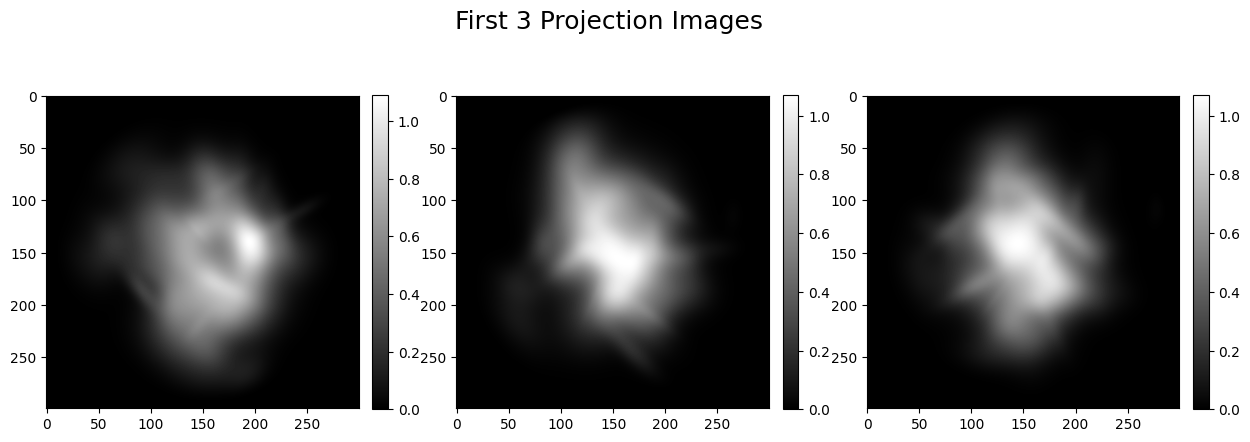

Calculate Autocorreltations: Done


/scratch/idohadi/CryoSymmetryDetection/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/idohadi/CryoSymmetryDetection/.env/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/scratch/idohadi/CryoSymmetryDetection/.env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


2024-08-06 23:53:56,467 WARNING [matplotlib.backends.backend_ps] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-08-06 23:53:57,034 WARNING [matplotlib.backends.backend_ps] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2024-08-06 23:53:57,594 WARNING [matplotlib.backends.backend_ps] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


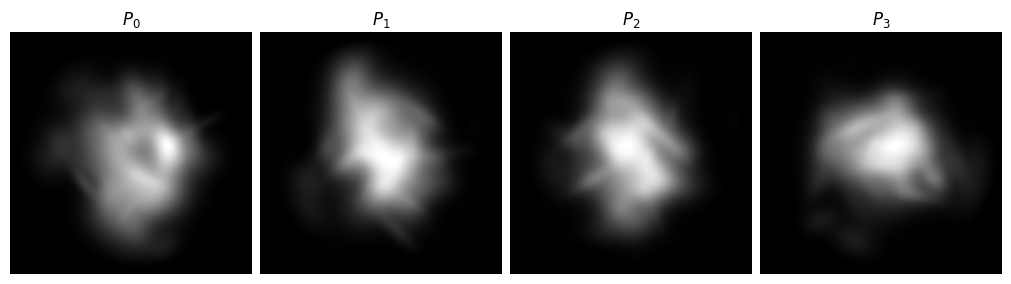

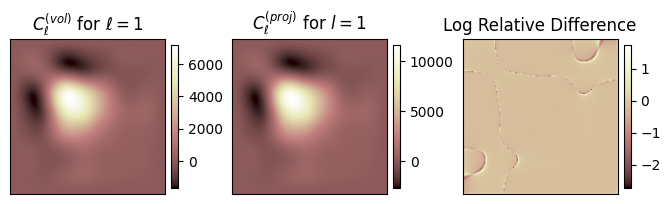

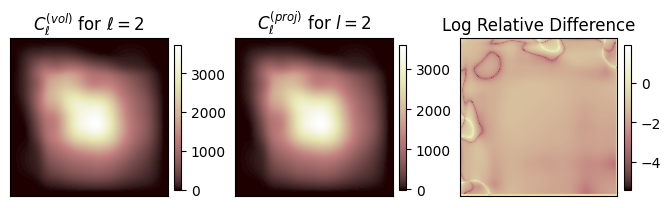

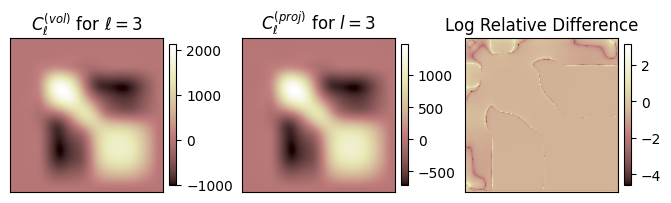

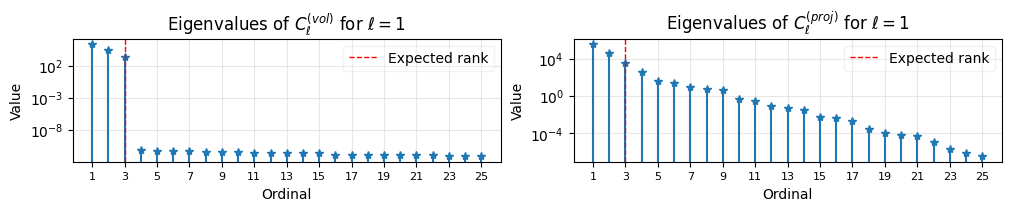

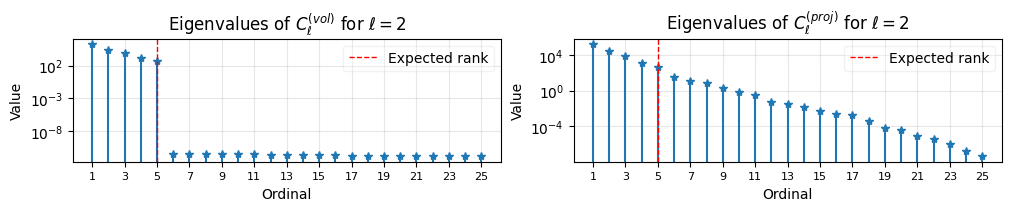

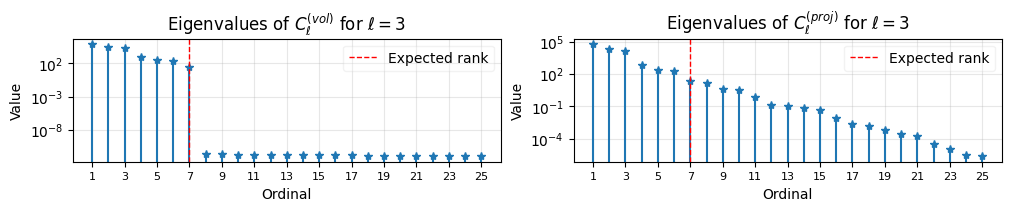

In [11]:
V_asym = vsynth.AsymmetricVolume(300, 1,seed=888, dtype=np.float64).generate()
V_asym, imgs_asym, acs_asym, img_acs_asym = runTest(symmetry_str="Asymmetric", V=V_asym,vol_basis=vol_basis, img_basis = img_basis)

#  ==========================================
# Plot and save 4 projection images
#  ==========================================
subplots_proj(imgs_asym[:4])
plt.savefig('imgs_asym.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save spectral analysis
#  ==========================================

ell_max = 3

for ell in range(1,ell_max+1):
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = img_acs_asym[ell-1]
    vol_ac = acs_asym[ell-1]

    subplot_ac(vol_ac,img_ac,ell)
    plt.savefig(f'asym_c{ell}_plots.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save C_l and C_l-proj comparison:
#  ==========================================
for ell in range(1,ell_max+1):
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = img_acs_asym[ell-1]
    vol_ac = acs_asym[ell-1]
    
    # Approximate eigenvalues
    img_eig = sl.eigvals(img_ac)
    vol_eig = sl.eigvals(vol_ac)

    # Sort the eigenvalues in ascending order
    img_eig[::-1].sort()
    vol_eig[::-1].sort()

    subplot_stem(vol_eig,img_eig,ell,symmetry_str="Asymmetric")

    plt.savefig(f'asym_c{ell}_spectrum.eps', format='eps', dpi=1200)

## Real Volumes

### D4 Volume
Volume:[ 6U8](https://www.rcsb.org/structure/6U8E)D4")

In [ ]:
path = "vols/emd_20687.map"
V_D4r, imgs_D4r, acs_D4r, imgs_acs_D4r = runTest(volume_path=path, symmetry_str="D4",vol_basis=vol_basis, img_basis = img_basis)

#  ==========================================
# Plot and save 4 projection images
#  ==========================================
subplots_proj(imgs_D4r[:4])
plt.savefig('imgs_D4r.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save spectral analysis
#  ==========================================
img_acs = imgs_acs_D4r
vol_acs = acs_D4r

for ell in [2,4,5]:
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = img_acs[ell-1]
    vol_ac = vol_acs[ell-1]

    subplot_ac(vol_ac,img_ac,ell)

    plt.savefig(f'D4sym_c{ell}_plots.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save C_l and C_l-proj comparison:
#  ==========================================

for ell in [2,4,5]:
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = img_acs[ell-1]
    vol_ac = vol_acs[ell-1]
    
    # Approximate eigenvalues
    img_eig = sl.eigvals(img_ac)
    vol_eig = sl.eigvals(vol_ac)

    # Sort the eigenvalues in ascending order
    img_eig[::-1].sort()
    vol_eig[::-1].sort()

    subplot_stem(vol_eig,img_eig,ell,symmetry_str="D4")

    plt.savefig(f'D4sym_c{ell}_spectrum.eps', format='eps', dpi=1200)

### T12 Volume

Volume:[ 6KP](https://www.rcsb.org/structure/6KPA)12")

In [ ]:
path = "vols/emd_0742.map"
V_T12r, imgs_T12r, acs_T12r, imgs_acs_T12r = runTest(volume_path=path, symmetry_str="T12",vol_basis=vol_basis, img_basis = img_basis)

#  ==========================================
# Plot and save 4 projection images
#  ==========================================
subplots_proj(imgs_T12r[:4])
plt.savefig('imgs_T12r.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save spectral analysis
#  ==========================================
for ell in [3,4,6]:
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = imgs_acs_T12r[ell-1]
    vol_ac = acs_T12r[ell-1]

    subplot_ac(vol_ac,img_ac,ell)

    plt.savefig(f'T12sym_c{ell}_plots.eps', format='eps', dpi=100)

#  ==========================================
# Plot and save C_l and C_l-proj comparison:
#  ==========================================
for ell in [3,4,6]:
    # Get the auto-correlation function from order zero to order `ell`
    img_ac = imgs_acs_T12r[ell-1]
    vol_ac = acs_T12r[ell-1]
    
    # Approximate eigenvalues
    img_eig = sl.eigvals(img_ac)
    vol_eig = sl.eigvals(vol_ac)

    # Sort the eigenvalues in ascending order
    img_eig[::-1].sort()
    vol_eig[::-1].sort()

    subplot_stem(vol_eig,img_eig,ell,symmetry_str="T12")

    plt.savefig(f'T12sym_c{ell}_spectrum.eps', format='eps', dpi=1200)